
**Описание данных**


Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import timedelta
import numpy as np

# Загрузика данных 


In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
# названия колонок перевел в snake_case для удобства
for k in [visits, orders, costs]:
    k.columns = ['_'.join(i.strip().lower().split(' ')) for i in k.columns.values]

## visits

In [4]:
visits.head()

user_id         region   device  channel        session_start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           session_end  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

In [5]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [6]:
visits.describe()

user_id
count  3.099010e+05
mean   4.997664e+11
std    2.887899e+11
min    5.993260e+05
25%    2.493691e+11
50%    4.989906e+11
75%    7.495211e+11
max    9.999996e+11

Пропусков в таблице `visits` нет, отрицательных значений тоже.

In [7]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [8]:
visits.dtypes

user_id                   int64
region                   object
device                   object
channel                  object
session_start    datetime64[ns]
session_end      datetime64[ns]
dtype: object

## orders

In [9]:
orders.head()

user_id             event_dt  revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [11]:
orders.describe()

user_id       revenue
count  4.021200e+04  40212.000000
mean   4.990295e+11      5.370608
std    2.860937e+11      3.454208
min    5.993260e+05      4.990000
25%    2.511324e+11      4.990000
50%    4.982840e+11      4.990000
75%    7.433327e+11      4.990000
max    9.998954e+11     49.990000

In [12]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [13]:
orders.dtypes

user_id              int64
event_dt    datetime64[ns]
revenue            float64
dtype: object

## costs

In [14]:
costs.head()

dt   channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

In [15]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [16]:
costs.describe()

costs
count  1800.000000
mean     58.609611
std     107.740223
min       0.800000
25%       6.495000
50%      12.285000
75%      33.600000
max     630.000000

In [17]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [18]:
costs.dtypes

dt          object
channel     object
costs      float64
dtype: object

Пропусков не обнаружено, проделано приведение типов данных.

# Функции анализа LTV, ROI, удержания и конверсии


In [19]:
# функция для создания пользовательских профилей

def get_profiles(sessions, 
                 orders,
                #events,
                 ad_costs
                 #event_names=[]
                ):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
#     for event in event_names:
#         if event in events['event_name'].unique():
#             profiles[event] = profiles['user_id'].isin(
#                 events.query('event_name == @event')['user_id'].unique()
#             )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [20]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [21]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [22]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(25, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

# EDA

- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [23]:
profiles = get_profiles(visits, orders, costs)

In [24]:
profiles

user_id            first_ts       channel  device         region  \
0             599326 2019-05-07 20:58:57      FaceBoom     Mac  United States   
1            4919697 2019-07-09 12:46:07      FaceBoom  iPhone  United States   
2            6085896 2019-10-01 09:58:33       organic  iPhone         France   
3           22593348 2019-08-22 21:35:48    AdNonSense      PC        Germany   
4           31989216 2019-10-02 00:07:44       YRabbit  iPhone  United States   
...              ...                 ...           ...     ...            ...   
150003  999956196527 2019-09-28 08:33:02        TipTop  iPhone  United States   
150004  999975439887 2019-10-21 00:35:17       organic      PC             UK   
150005  999976332130 2019-07-23 02:57:06        TipTop  iPhone  United States   
150006  999979924135 2019-09-28 21:28:09  MediaTornado      PC  United States   
150007  999999563947 2019-10-18 19:57:25       organic  iPhone  United States   

                dt      month  payer  acquisition_cost  
0       2019-05-07 2019-05-01   True          1.088172  
1       2019-07-09 2019-07-01  False          1.107237  
2       2019-10-01 2019-10-01  False          0.000000  
3       2019-08-22 2019-08-01  False          0.988235  
4       2019-10-02 2019-10-01  False          0.230769  
...            ...        ...    ...               ...  
150003  2019-09-28 2019-09-01  False          3.500000  
150004  2019-10-21 2019-10-01  False          0.000000  
150005  2019-07-23 2019-07-01  False          2.600000  
150006  2019-09-28 2019-09-01  False          0.205714  
150007  2019-10-18 2019-10-01  False          0.000000  

[150008 rows x 9 columns]

In [25]:
profiles.duplicated().sum()

0

In [26]:
profiles.isna().sum()

user_id             0
first_ts            0
channel             0
device              0
region              0
dt                  0
month               0
payer               0
acquisition_cost    0
dtype: int64

In [27]:
profiles['dt'].agg({'min_data': 'min', 'max_data': 'max'})

min_data    2019-05-01
max_data    2019-10-27
Name: dt, dtype: object

У нас данные с 1 мая по 27 октября. Всё сходится.

## Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?

In [28]:
px.bar(profiles.groupby(['region', 'payer']).agg({'user_id': 'nunique'}).reset_index(),
       x='region', y='user_id',
       color='payer',
       height=500, title='Количество платящих и неплатящих пользователей по странам')

По графику видно, что поток приходящих пользователей из США больше трех европейских регионов, вместе взятых.
Количество платящих пользователей также лидирует для пользователей США.

## Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?

In [29]:
px.bar(profiles.groupby(['region', 'device']).agg({'user_id': 'nunique'}).reset_index(),
       y='device', x='user_id', orientation='h',
       color='region', title='Количество пользователей по девайсам и странам')

Из этого графика видно, что больше всего пользователей с мобильных платформ пользуются услугами рассматриваемого сервиса.

In [30]:
px.bar(profiles.query('payer == True').groupby(['region', 'device']) \
       .agg({'user_id': 'nunique'}).reset_index(),
       y='device', x='user_id', orientation='h',
       color='region', title='Количество платящих пользователей по девайсам и странам')

А из этого графика видно, что платящие пользователи в основном используют iPhone и они изи США. Для регионов Европы это PC

## По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [31]:
px.bar(profiles.groupby(['region', 'channel']).agg({'user_id': 'nunique'}).reset_index(),
       y='channel', x='user_id', orientation='h',
       color='region', title='Количество пользователей по каналам привлечения')

In [32]:
px.bar(profiles.query('payer == True').groupby(['region', 'channel']) \
       .agg({'user_id': 'nunique'}).reset_index(),
       y='channel', x='user_id', orientation='h',
       color='region', title='Количество платящих пользователей по каналам привлечения')

Из этих двух графиков видно, что существуют два типа каналов. Те, которые работают в США и Европе + органика для всех. Больше всего пользователей приходит из каналов США -- FaceBoom, TipTop. Также видно, что в регионах европы в сумме органический канал приносит примерно столько же, сколько топовые рекламные компании -- WahooNetBanner или AdNonSense

# Маркетинг

## Сколько денег потратили? Всего / на каждый источник / по времени

In [33]:
px.bar(profiles.agg({'acquisition_cost': 'sum'}),
       height=250, orientation='h',
       title='Количество денег, потраченных на маркетинг')

Компания потратила 106 тысяч долларов на все рекламные компании

In [34]:
px.bar(profiles.groupby('channel') \
       .agg({'acquisition_cost': 'sum'}) \
       .sort_values('acquisition_cost', ascending=False).reset_index(),
       x='channel', y='acquisition_cost',
       title='Количество денег, потраченных на канал привлечения')

Те самые 4 топовых канала в топе по тратам денег на них. Можно предположить, что реклама в США работает лучше, чем в Европе, но этих графиков пока недостаточно, чтобы точно сделать такой вывод.

In [35]:
px.bar(profiles.groupby('month').agg({'acquisition_cost': 'sum'}).reset_index(),
       x='month', y='acquisition_cost', height=500,
       title='Месячные траты на маркетинг')

В сентябре потратили больше всего денег на рекламу. Больше 20 тысяч долларов

In [36]:
px.bar(profiles.groupby('dt').agg({'acquisition_cost': 'sum'}).reset_index(),
       x='dt', y='acquisition_cost', height=450,
       title='Дневные траты на маркетинг')

28 сентября 1075 долларов - максимально, а 15 мая 230 долларов - минимально

## Сколько в среднем стоило привлечение одного покупателя из каждого источника?

In [37]:
px.bar(profiles.groupby('channel').agg({'acquisition_cost': 'mean'})\
       .sort_values('acquisition_cost', ascending=False).reset_index(),
       x='channel', y='acquisition_cost', height=450,
       title='Месячные траты на маркетинг')

В TipTop оочень дорогие пользователи. Большее чем в 2 раза дороже, чем предшественник.

# Оценка окупаемости рекламы для привлечения пользователей

- Общая окупаемость рекламы;
- Окупаемость рекламы с разбивкой по устройствам;
- Окупаемость рекламы с разбивкой по странам;
- Окупаемость рекламы с разбивкой по рекламным каналам.

In [38]:
observ_date = profiles.first_ts.max()
horizon_days = 14

### Проанализируйте общую окупаемость рекламы

In [39]:
ltv_raw, ltv, ltv_hist, roi, roi_hist = get_ltv(profiles.\
                                                query('channel != "organic"'),
                                                orders,
                                                observ_date, 
                                                horizon_days,
                                                dimensions=[])

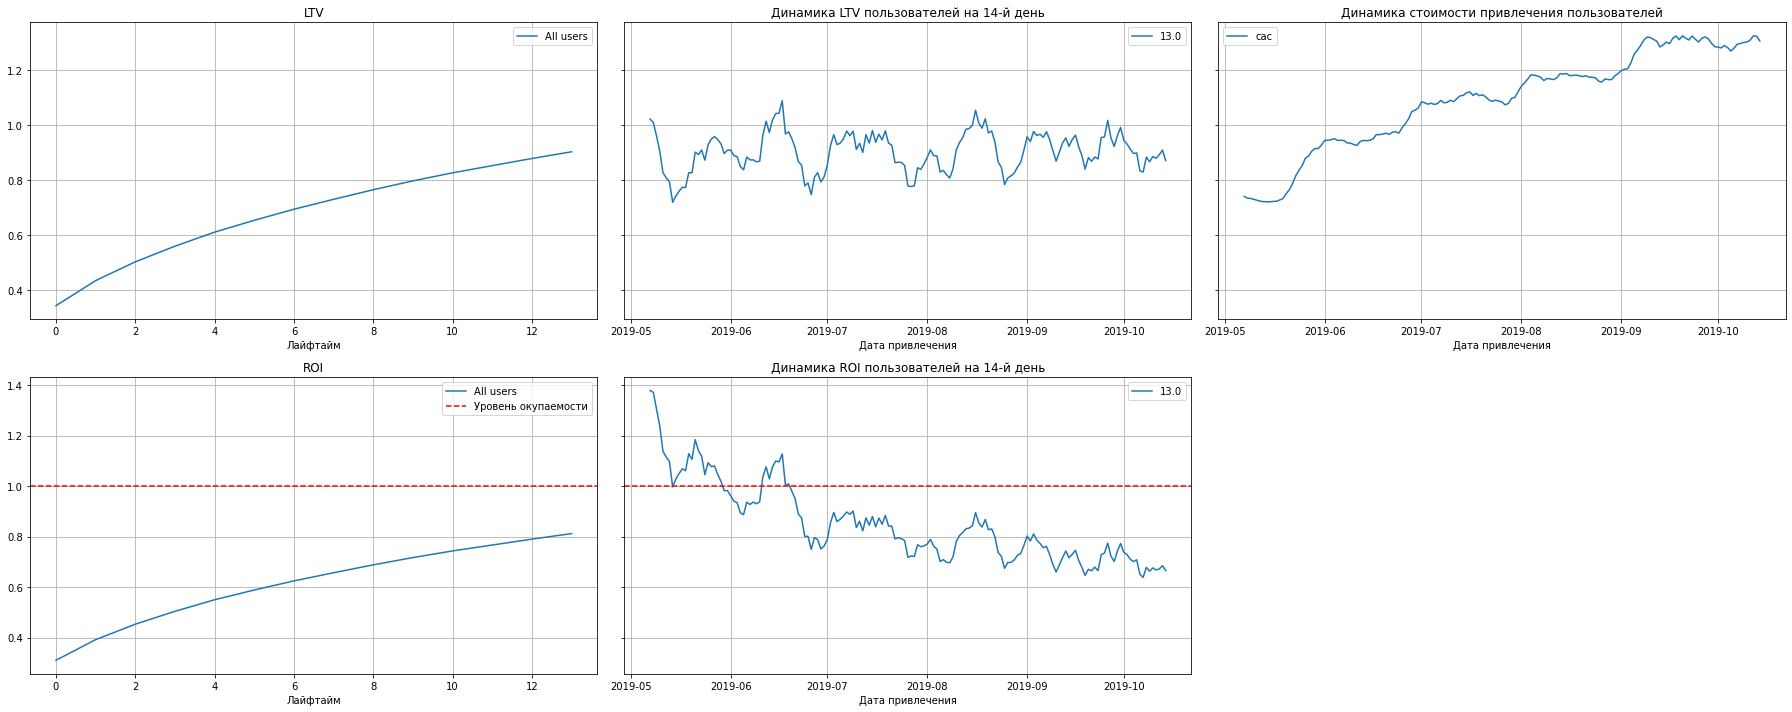

In [40]:
plot_ltv_roi(ltv, ltv_hist, roi, roi_hist, horizon_days, window=7)

ROI за 14 дней так и не дошел до линии оккупаемости. За 14 дней мы не успели выйти в 0 от закупки рекламы. Еще одна печаль в том, что динамика ROI падает. То есть сам график ROI становится параллелен оси ox, рост замедляется. Стоимость привлечения пользователя дорожает.

### Проанализируйте окупаемость рекламы с разбивкой по устройствам

In [41]:
ltv_raw, ltv, ltv_hist, roi, roi_hist = get_ltv(profiles.query('channel != "organic"'),
                                                orders,
                                                observ_date, 
                                                horizon_days,
                                                dimensions=['device'])

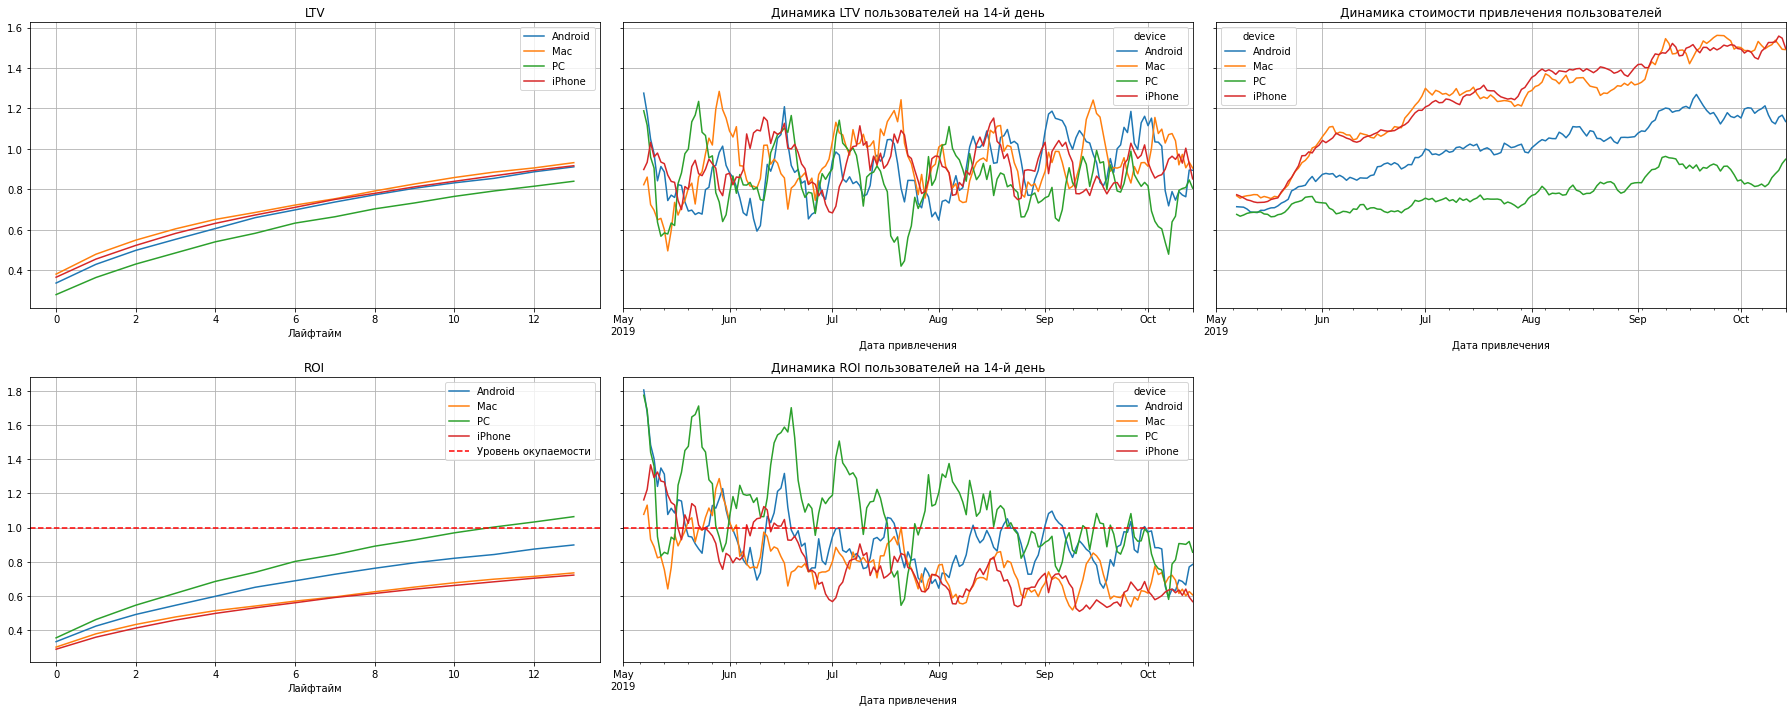

In [42]:
plot_ltv_roi(ltv, ltv_hist, roi, roi_hist, horizon_days, window=7)

Из этого нрафика видно, что пользователи устройств Apple и Android не окупились к концу лайфтайма. А вот пользователи PC, значительная доля которых европейские пользователи, успели окупиться и принести небольшую прибыль.

### Проанализируйте окупаемость рекламы с разбивкой по странам

In [43]:
ltv_raw, ltv, ltv_hist, roi, roi_hist = get_ltv(profiles.query('channel != "Organic"'),
                                                orders,
                                                observ_date, 
                                                horizon_days,
                                                dimensions=['region'])

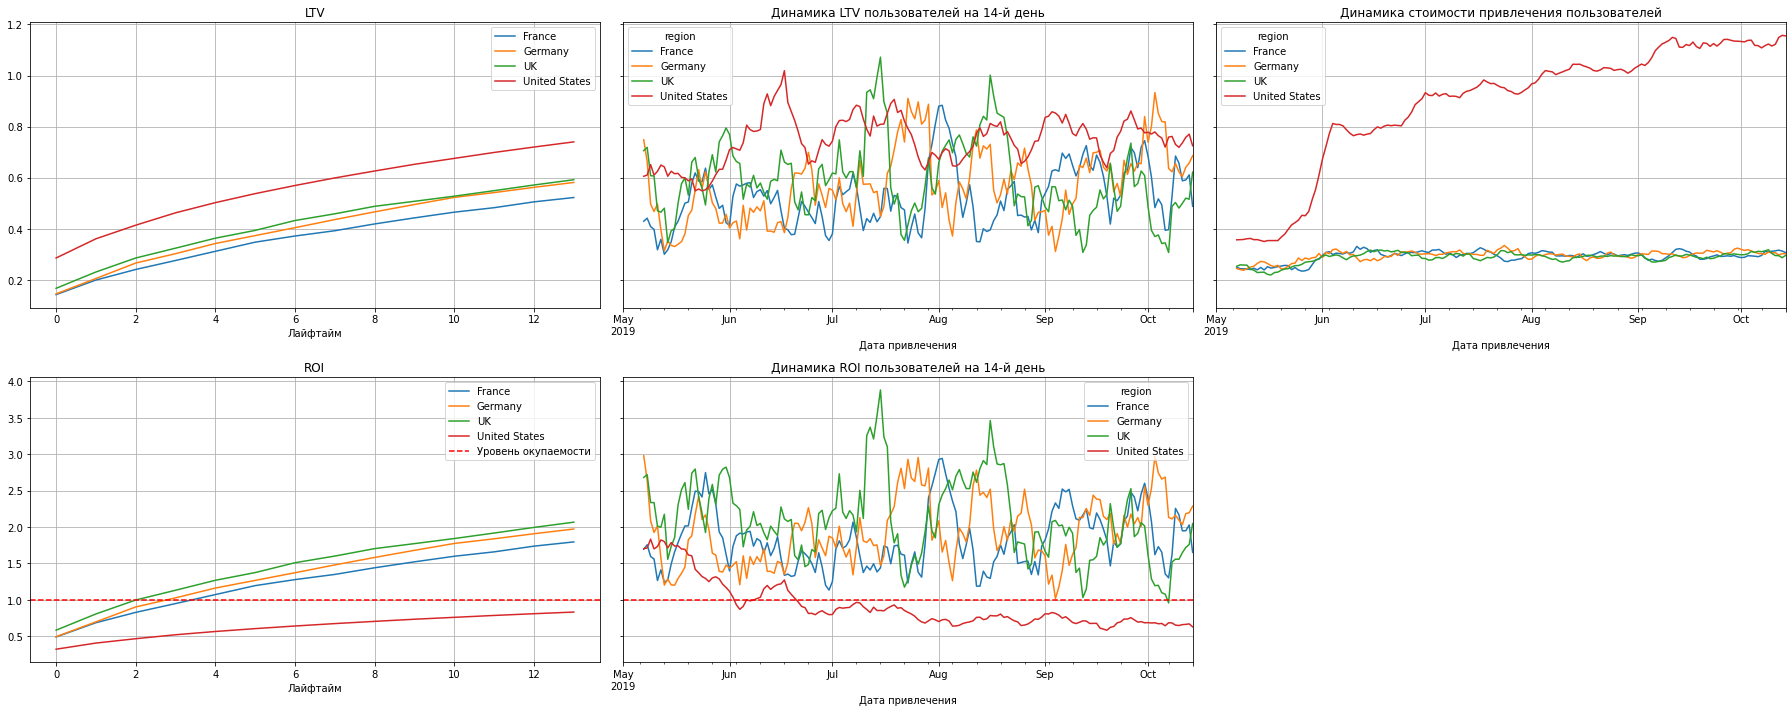

In [44]:
plot_ltv_roi(ltv, ltv_hist, roi, roi_hist, horizon_days, window=7)

Этот график подтверждает теорию. Европейские страны приносят нам прибыль, а вот США -- нет. ROI США растет очень медленно и не окупается. 

На графике стоимости привлечения одного юзера виден огромный отскок цены вверх. Это странно. Хорошо было бы разобраться почему пользователи стоят так дорого. Например, посмотреть личный кабинет закупки рекламы самого дорогого канала TipTop'а, написать в поддержку.

### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам

In [45]:
ltv_raw, ltv, ltv_hist, roi, roi_hist = get_ltv(profiles.query('channel != "organic"'),
                                                orders,
                                                observ_date, 
                                                horizon_days,
                                                dimensions=['channel'])

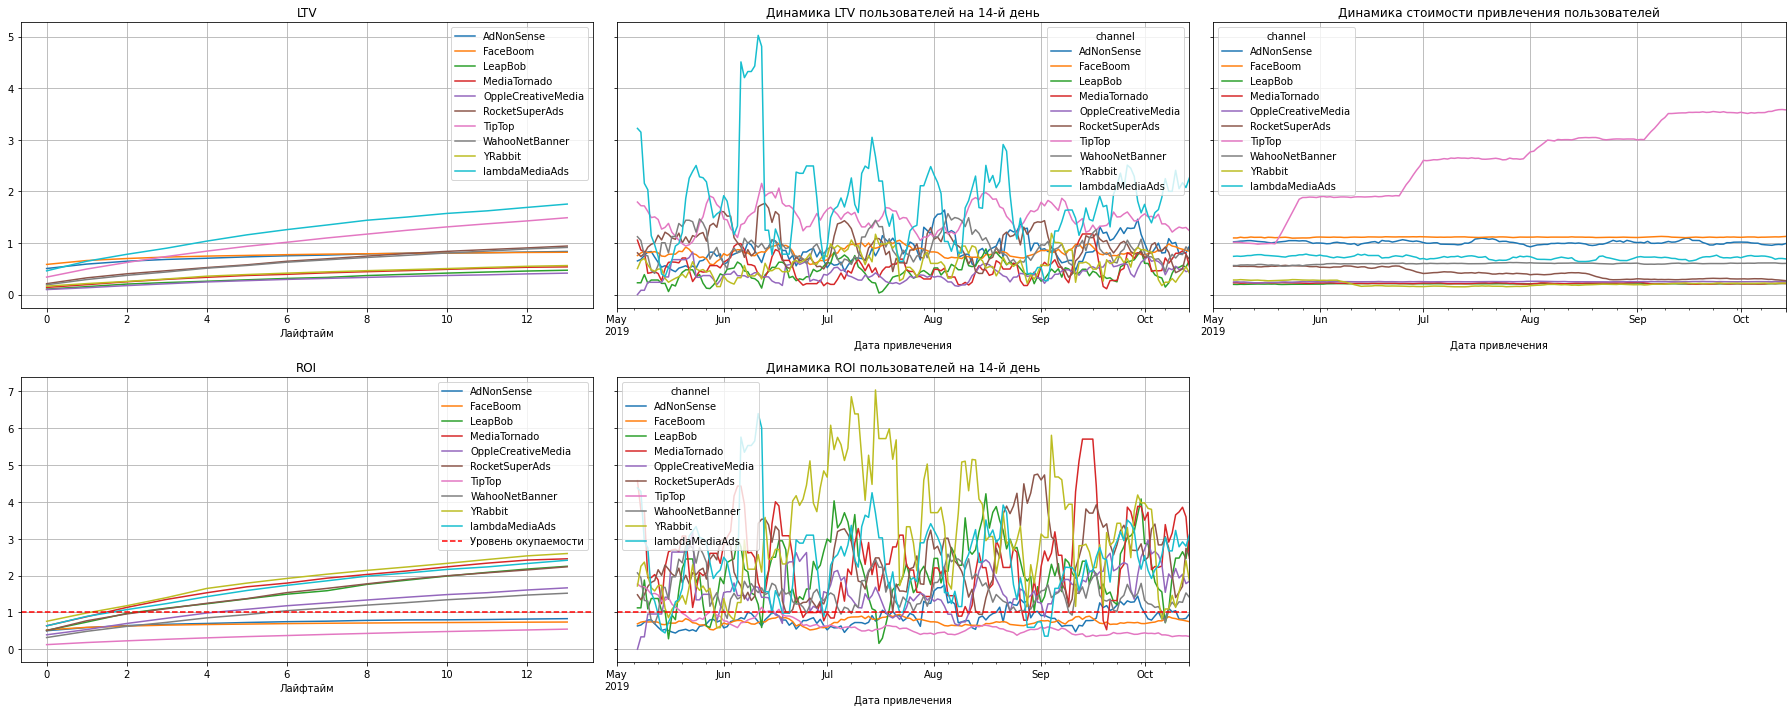

In [46]:
plot_ltv_roi(ltv, ltv_hist, roi, roi_hist, horizon_days, window=7)

А вот еще один график, который подтверждает, что причина наших убытков канал ТикТока. Стоимость пользователя там растет сумасшедшими темпами. Почти как перевернутая награда за блок в сети биткоина. От этой сети пора отказаться на время, пока эта проблема не устранится, иначе компания рискует потерять очень много денег. 

Также видно, что каналы AdNonSence и FaceBoom не успевают окупиться. Динамика их ROI тоже не очень хорошая. Стабильно ниже единицы.

TipTop, Faceboom и AdNonSense - крупные сети. Там как правило реклама стоит действительно дороже. Но по графикам она менее эффективная. Пользователи там одни из самых дорогих, а вот прибыли с них не много. Нужно решить эту проблему. Один из выходов -- отказаться от этих каналов привлечения, или закупать там меньше юзеров.

# Шаг 6. Напишите выводы
- Выделите причины неэффективности привлечения пользователей;
- Сформируйте рекомендации для отдела маркетинга для повышения эффективности.

Как было сказано выше, основная причина неэффективности привлечения пользователей - сильные скачки стоимости пользователей в сети тикток. Настоятельно рекомендую ограничить поток денег в этот канал до минимума!

Дело тут не в том, что канал "плохой". Наоборот, один из самых мощных LTV. Но стоимость пользователей очень большая. Если выяснится, что это ошибка на стороне ТикТока, то в этом канале настоятельно рекомендуется закупать пользователей и дальше, за меньшую стоимость.

Также рекомендую тонко отрегулировать денежные потоки в каналы Фейсбука и АдСенса, потому что они сейчас тоже убыточны.

Лучше всего будет перераспределить деньги с убыточных каналов, на самые прибыльные.

Например, lambdaMediaAds, RocketSuperAds, YRabbit, MediaTornado

Отмечу, что регион США у нас убыточный из за канала привлечения ТикТока. Менять направление развития с Америки на Европу в данном случае точно не стоит. У этой страны хороший LTV, в перспективе она приносит хорошие деньги, если грамотно распределить деньги на рекламу.